# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

---
## 2. Load data

In [3]:
dt_st = ['date_activ','date_end','date_modif_prod','date_renewal']
df = pd.read_csv('D:\\bcg_internship\\client_data.csv',parse_dates=dt_st)
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [4]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [5]:
price_df = pd.read_csv('D:\\bcg_internship\\price_data.csv',parse_dates=['price_date'])
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-12,0.145859,0.000000,0.000000,44.444710,0.00000,0.000000
1,31f2ce549924679a3cbb2d128ae9ea43,2015-01-12,0.118755,0.101071,0.075096,40.728885,24.43733,16.291555
2,36b6352b4656216bfdb96f01e9a94b4e,2015-01-12,0.113068,0.095385,0.069409,40.728885,24.43733,16.291555
3,48f3e6e86f7a8656b2c6b6ce2763055e,2015-01-12,0.143943,0.000000,0.000000,44.444710,0.00000,0.000000
4,cce88c7d721430d8bd31f71ae686c91e,2015-01-12,0.113827,0.097371,0.069794,40.728885,24.43733,16.291555


In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [7]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-07-03,2010-01-13,2015-09-03,445.75,...,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916


# Average price changes across periods

In [8]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [9]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [10]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,13.800,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,13.856,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,13.200,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-07-03,2010-01-13,2015-09-03,445.75,...,19.800,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


# Max price changes across periods and months

In [11]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [12]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [13]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [14]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-07-03,2010-01-13,2015-09-03,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


# (BONUS) Further feature engineering¶

In [15]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

In [16]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
2,0.142857
3,0.136564
4,0.125399
13,0.100000
5,0.084349
6,0.080227
12,0.074627
7,0.073820
11,0.073171


In [17]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [18]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [19]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0,1.78,0.114481,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,11,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0,16.27,0.145711,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0,38.72,0.165794,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0,19.83,0.146694,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0,131.73,0.116900,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,6,71,3


# Transforming Boolean data¶

In [20]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


In [21]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [22]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,...,3,30,5,11,6,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,...,7,76,7,76,4,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0,38.72,0.165794,0.087899,...,6,68,3,68,8,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,...,6,69,2,69,9,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,...,6,71,6,71,3,1,0,0,0,0


In [23]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [24]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,...,11,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0,38.72,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,...,71,3,1,0,0,0,0,1,0,0


In [25]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [26]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [27]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


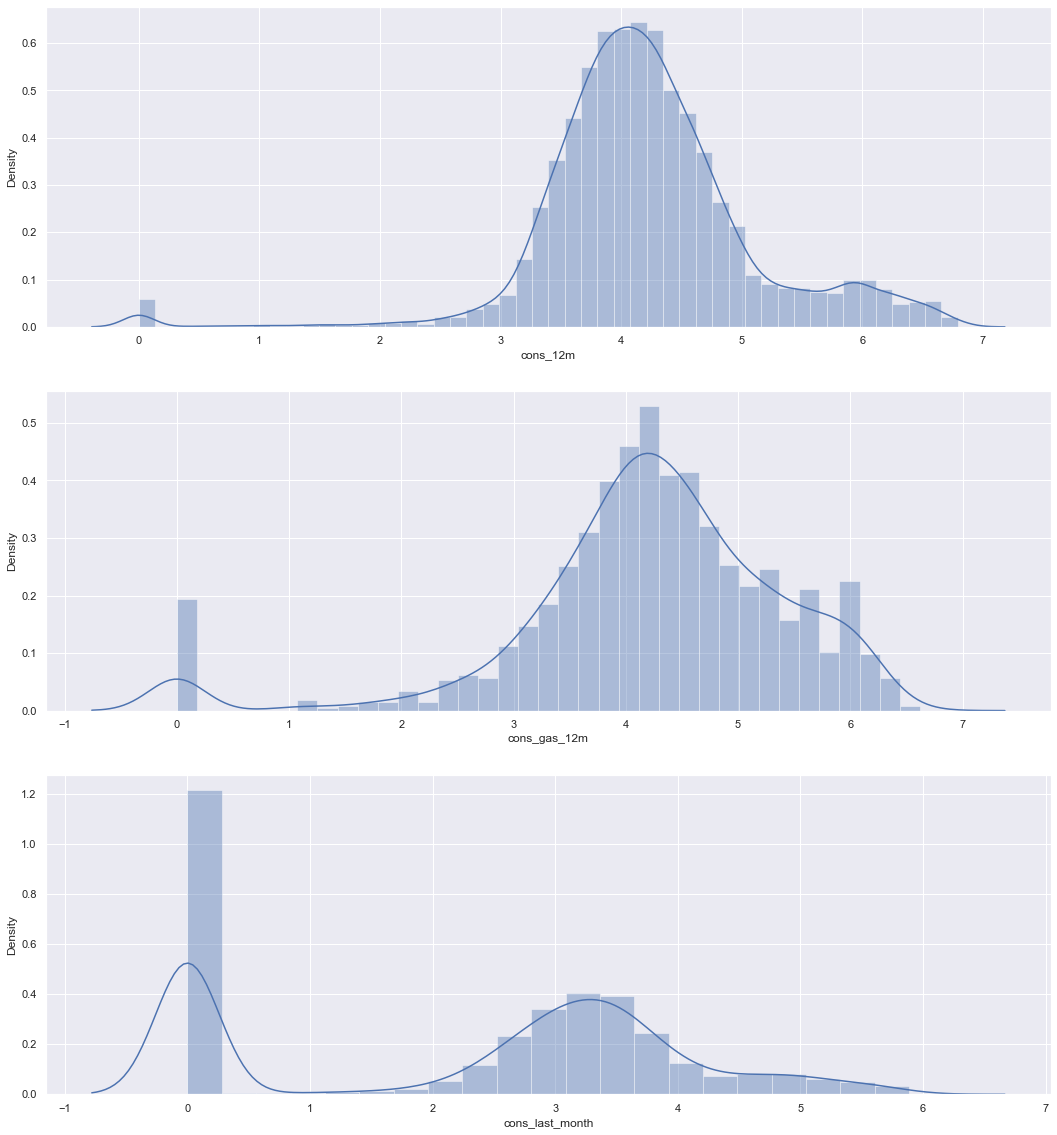

In [28]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

In [29]:
correlation = df.corr()

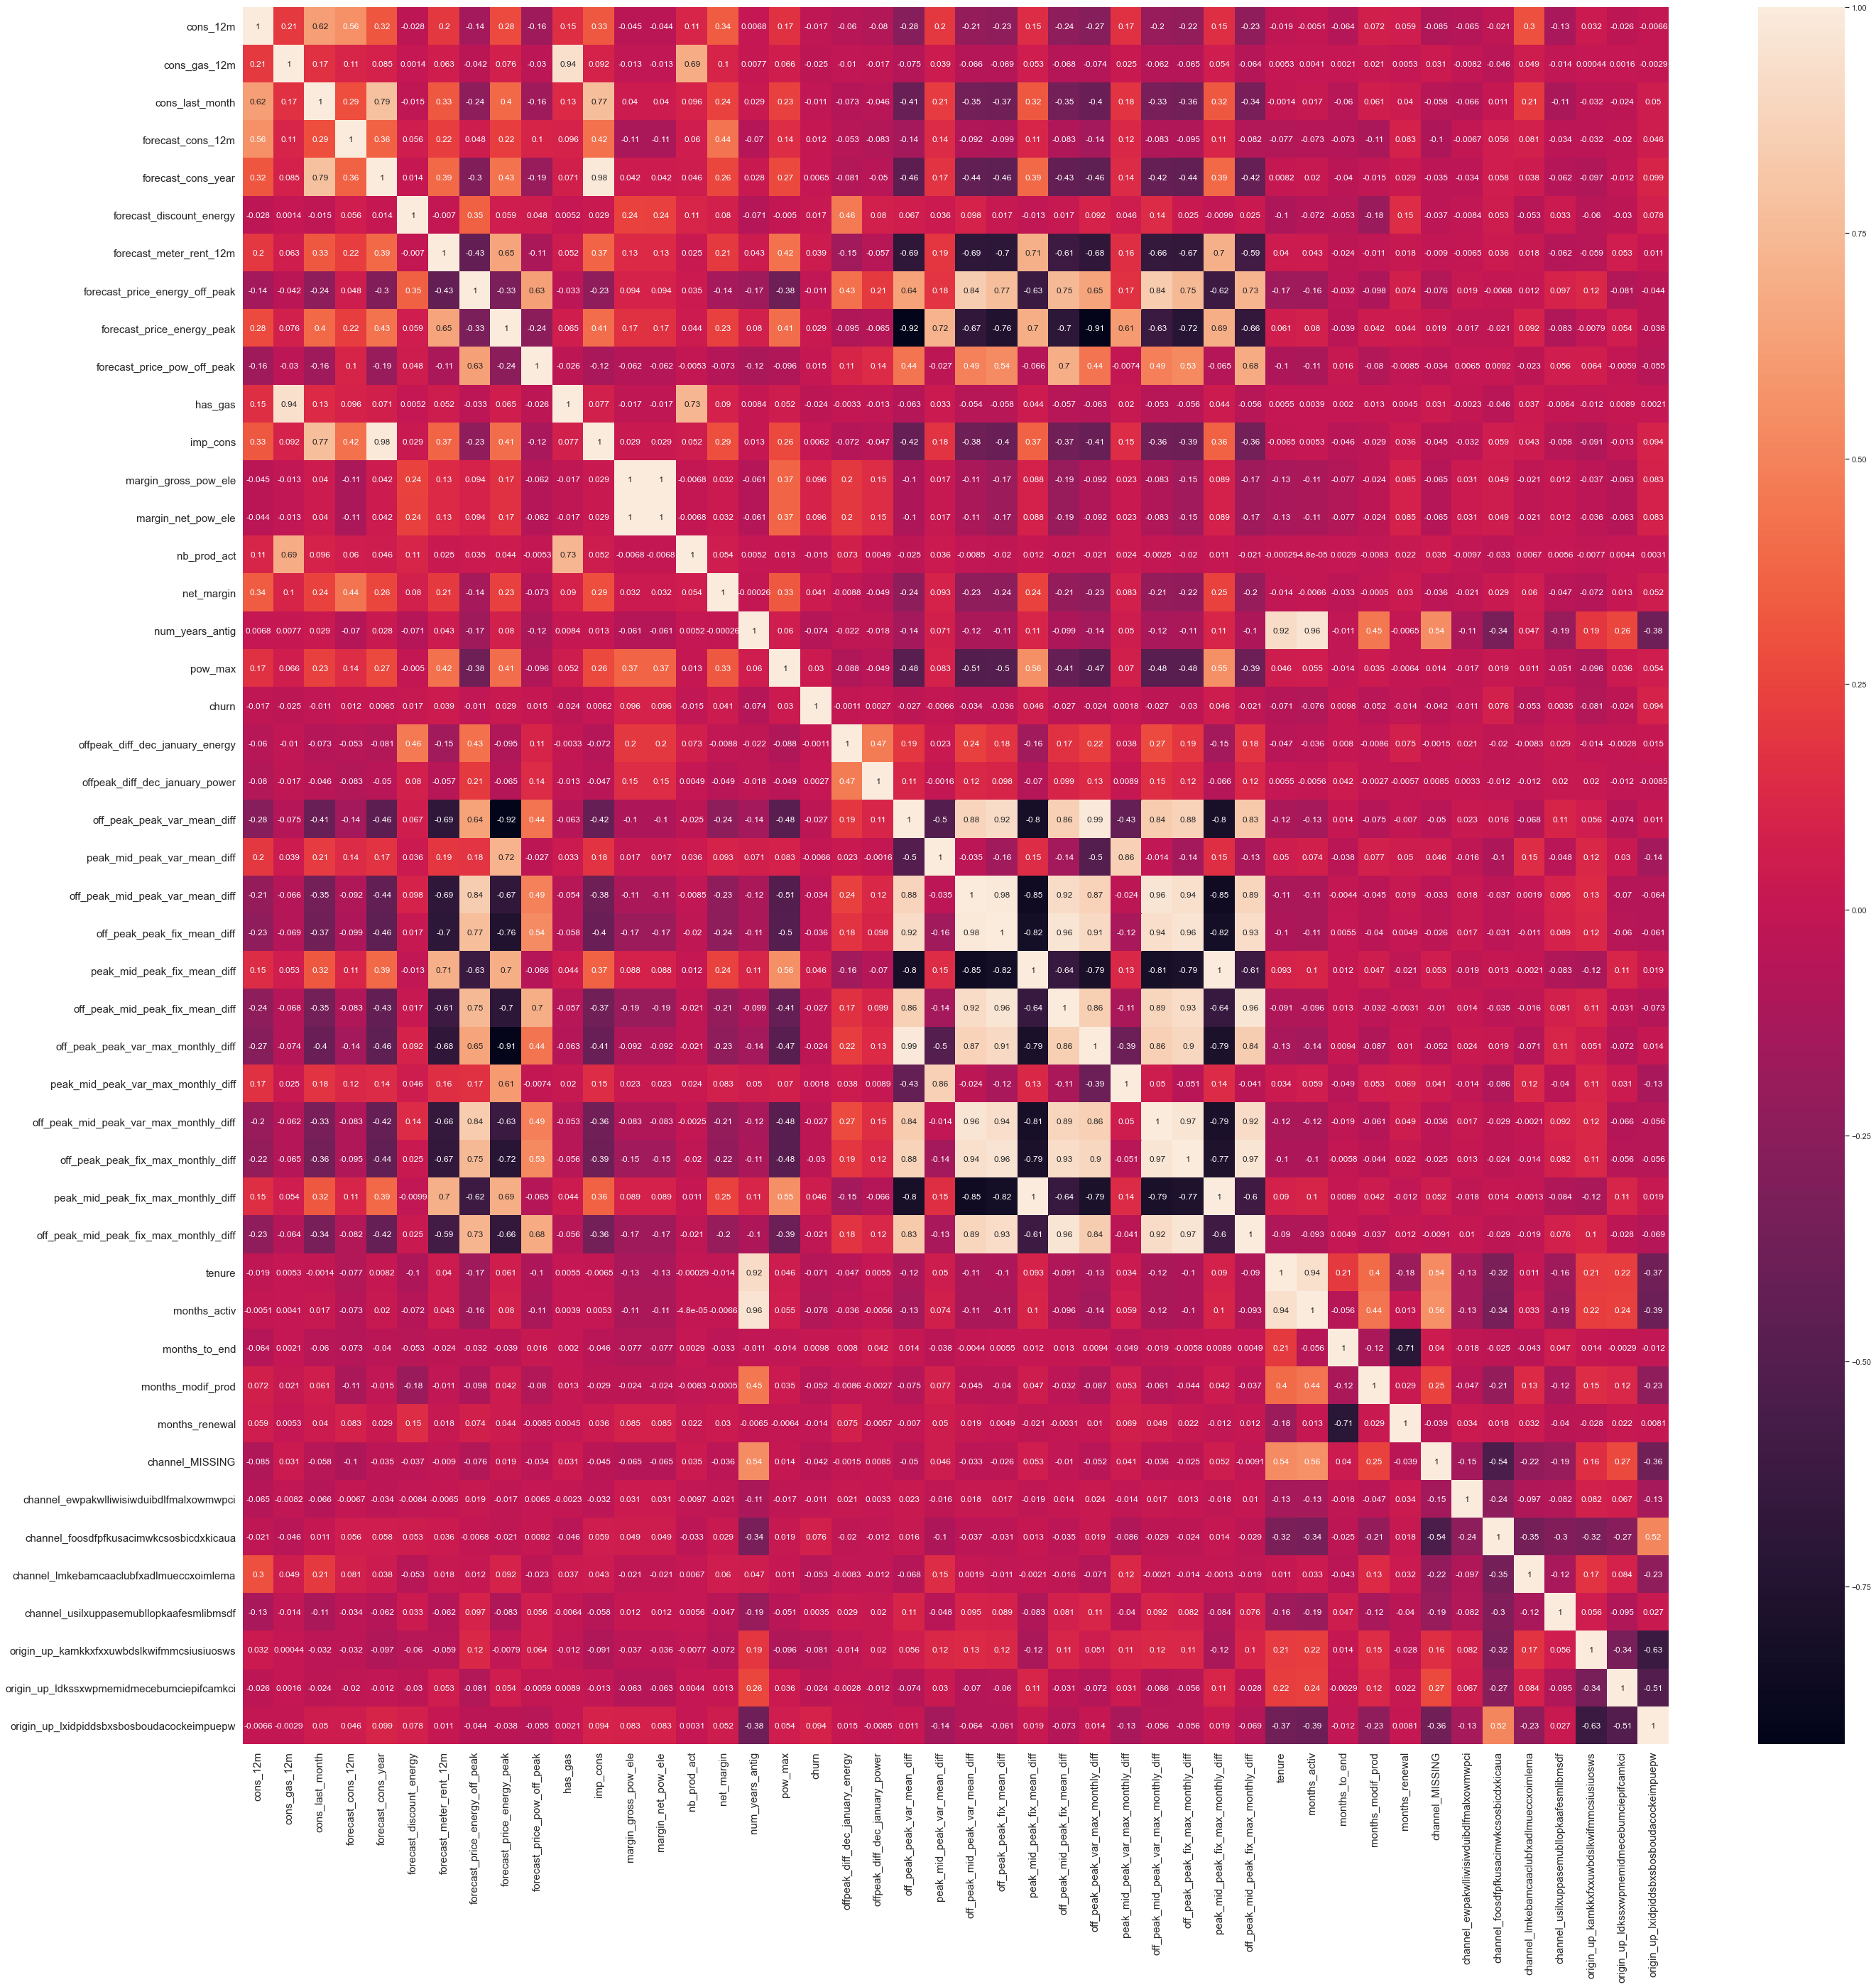

In [30]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [31]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0,0.444045,0.114481,0.098142,40.606701,...,11,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0,2.122969,0.116900,0.100015,40.606701,...,71,3,1,0,0,0,0,1,0,0


In [32]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 43)
(14606,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 43)
(10954,)
(3652, 43)
(3652,)


In [35]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [36]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [37]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [38]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 16
False positives: 2
True negatives: 3284
False negatives: 350

Accuracy: 0.9036144578313253
Precision: 0.8888888888888888
Recall: 0.04371584699453552


In [39]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


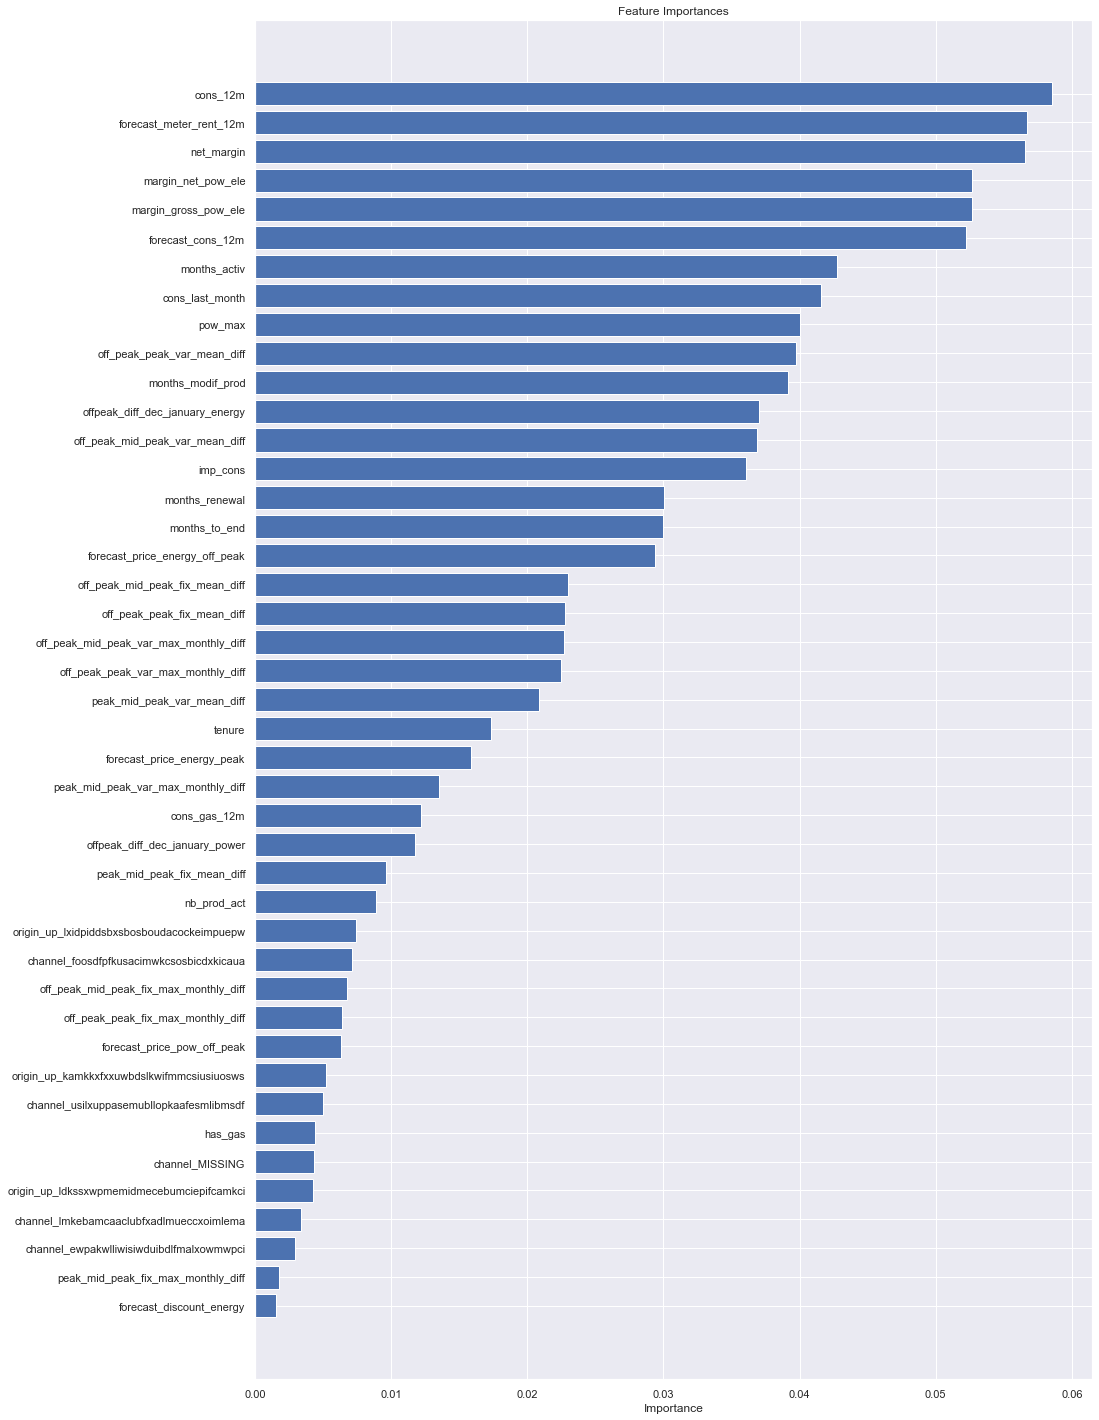

In [40]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [41]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [42]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [43]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')